In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.io as sio
import sys
sys.path.append('../helpers')
import loadmat as lm
from sklearn import linear_model
from scipy import signal
from sklearn.model_selection import cross_val_score, cross_validate
import os
from sklearn.metrics import make_scorer


In [47]:
cl_datasets = [r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npI1_0418_mismatch_4.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npJ1_0522_mismatchTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npAA1R_0419_mismatchTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\AA2R_0503_mismatchTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npH3_0404_mismatch_1.mat'
          ]

In [48]:
ol_datasets = [r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npI1_0418_playback_4.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npJ1_0522_playbackTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npAA1R_0419_playbackTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\AA2R_0503_playbackTowers_1.mat',
           r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npH3_0404_playback_1.mat'
          ]

# Load cl data and train classifier

In [36]:
def preprocess(data):
    track_start = 0
    track_end = 400
    dx=5
    dt=0.2
    every_nth_time_bin = 10
    numposbins = np.floor((track_end-track_start)/dx)
    posx_edges = np.linspace(track_start,track_end,numposbins+1)
    posx=data['posx']
    post=data['post']
    trial = data['trial']
    sp =  data['sp']
    # resample post, posx, and trial according to desired dt
    post_resampled = post[0::every_nth_time_bin]
    posx_resampled = posx[0::every_nth_time_bin]
    trial_resampled = trial[0::every_nth_time_bin]

    # get cell ids of "good" units
    good_cells = sp['cids'][sp['cgs']==2]

    # time bins for position decoding
    numtimebins = len(post_resampled)
    post_edges = np.squeeze(np.linspace(min(post)-dt/2,max(post)+dt/2,numtimebins+1))
    post_centers = post_edges[range(0,len(post_edges)-1)]+dt/2

    # posx categories for position decoding (binned)
    posx_bin = np.digitize(posx_resampled,posx_edges)

    # count spikes in each time bin for each cell
    spikecount = np.empty((len(good_cells),len(post_resampled),))
    spikecount[:] = np.nan
    for cell_idx in range(len(good_cells)):   
        spike_t = sp['st'][sp['clu']==good_cells[cell_idx]]
        spikecount[cell_idx,:] = np.histogram(spike_t,bins=post_edges)[0]
    data['spikecount']=np.transpose(spikecount)
    data['posx_bin']=posx_bin
    return data

In [52]:
def custom_score(y, y_pred, **kwargs):
    return np.mean(np.sqrt((y-y_pred)**2))

In [29]:
cl_data = lm.loadmat(r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npI1_0418_mismatch_4.mat')

In [37]:
cl_data = preprocess(cl_data)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [56]:
def eval_and_train(dataset):
    scoring = {'prec_macro': 'precision_macro','custom_macro': make_scorer(custom_score)}
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    #scores = cross_val_score(model, , cv=5)
    scores = cross_validate(model,dataset['spikecount'],dataset['posx_bin'],scoring=scoring, cv=5,return_estimator=True)
    
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    model.fit(dataset['spikecount'],dataset['posx_bin'])
    return model,scores

In [41]:
def process_datasets(filenames):
    results=[]
    for fn in filenames:
        dataset=lm.loadmat(fn)
        dataset=preprocess(dataset)
        (model,scores)=eval_and_train(dataset)
        results.append((model,scores))
    return results
        

In [57]:
cl_results = process_datasets(cl_datasets)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  

In [65]:
bl_precision=[np.mean(x[1]['test_prec_macro']) for x in cl_results]

In [67]:
bl_custom=[np.mean(x[1]['test_custom_macro']) for x in cl_results]

In [73]:
def score_ol_data(ol_datasets,cl_results):
    eval_results = []
    for iF in range(len(cl_results)):
        dataset = lm.loadmat(ol_datasets[iF])
        dataset = preprocess(dataset)
        precision = cl_results[iF][0].score(dataset['spikecount'],dataset['posx_bin'])
        custom = custom_score(cl_results[iF][0].predict(dataset['spikecount']),dataset['posx_bin'])
        eval_results.append((precision,custom))
    return eval_results

In [74]:
ol_results = score_ol_data(ol_datasets,cl_results)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <

In [96]:
ol_precision = [x[0] for x in ol_results]
ol_custom = [x[1] for x in ol_results]

In [88]:
import seaborn as sns
import pandas as pd

In [104]:
precision = {'baseline':bl_precision, 'openloop':ol_precision}
precision = pd.DataFrame(precision)
custom = {'closedloop':bl_custom, 'openloop':ol_custom}
custom = pd.DataFrame(custom)

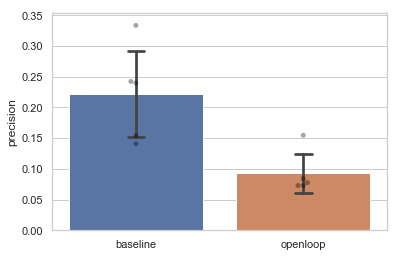

In [101]:
sns.set(style="whitegrid")

tips = sns.load_dataset("tips")

sns.barplot(data=precision, capsize=.1, ci="sd")
ax=sns.swarmplot(data=precision, color="0", alpha=.35)
ax.set(ylabel='precision')
plt.show()


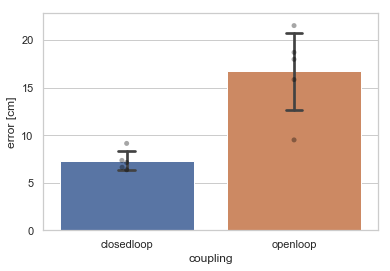

In [108]:
sns.set(style="whitegrid")

tips = sns.load_dataset("tips")

sns.barplot(data=custom, capsize=.1, ci="sd")
ax=sns.swarmplot(data=custom, color="0", alpha=.35)
ax.set(ylabel='error [cm]',xlabel='coupling')
plt.savefig('C:/temp/out_error.pdf')
plt.show()

In [109]:
ol_results = process_datasets(ol_datasets)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.

In [111]:
ol_precision=[np.mean(x[1]['test_prec_macro']) for x in cl_results]
ol_precision

[0.14081185532298587,
 0.1540033449949086,
 0.33343725980650246,
 0.2422070798574795,
 0.2397544985085605]